# Using Ensemble Methods for Regression

In [1]:
import pandas as pd

## Load and Prepare Our Data

For this example we will use the California Housing Prices dataset available here:
https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
df = pd.read_csv('./data/housing.csv')

Check how many rows we've read in.

In [3]:
len(df)

20640

Check for missing values.

In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Drop the 207 rows with missing data.

In [5]:
df = df.dropna()
len(df)

20433

Prepare our features and our labels.

In [6]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

Use 70% of the data for training and set aside 30% for testing.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42)

In [9]:
len(X_train)

14303

Note that I have avoided looking at the whole dataset or the test data. This is a good practice. If we examine the test data, we may apply optimizations specific to it, potentially overfitting our test data and making the model less reliable for unseen future data.

Of course it's fine to examine the training data, so here we'll create a convenient training data variable that includes both features and labels.

In [10]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
19566,-120.96,37.61,23.0,3497.0,887.0,2467.0,816.0,1.9444,INLAND,93400.0
7292,-118.22,33.98,34.0,2225.0,753.0,2980.0,736.0,1.6685,<1H OCEAN,128800.0
17618,-121.94,37.28,27.0,2859.0,464.0,1144.0,430.0,5.0822,<1H OCEAN,327500.0
17518,-121.91,37.34,35.0,2189.0,607.0,1193.0,562.0,2.8042,<1H OCEAN,240900.0
5172,-118.28,33.95,41.0,835.0,208.0,707.0,192.0,1.4103,<1H OCEAN,86200.0
...,...,...,...,...,...,...,...,...,...,...
11397,-117.97,33.72,24.0,2991.0,500.0,1437.0,453.0,5.4286,<1H OCEAN,273400.0
12081,-117.54,33.76,5.0,5846.0,1035.0,3258.0,1001.0,4.7965,<1H OCEAN,160800.0
5447,-118.42,34.01,42.0,1594.0,369.0,952.0,362.0,3.0990,<1H OCEAN,335400.0
866,-122.04,37.57,12.0,5719.0,1064.0,3436.0,1057.0,5.2879,NEAR BAY,231200.0


In [11]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,14303.0,-119.584295,2.003002,-124.3500,-121.81000,-118.5100,-118.01000,-114.4700
latitude,14303.0,35.643475,2.135749,32.5400,33.93000,34.2600,37.72000,41.9500
housing_median_age,14303.0,28.606376,12.593290,1.0000,18.00000,29.0000,37.00000,52.0000
total_rooms,14303.0,2630.016011,2171.311724,6.0000,1448.00000,2125.0000,3136.00000,39320.0000
total_bedrooms,14303.0,536.226736,420.328289,1.0000,296.00000,433.0000,645.00000,6445.0000
population,14303.0,1423.504090,1146.064810,3.0000,787.00000,1165.0000,1717.00000,35682.0000
households,14303.0,498.047542,380.603636,1.0000,281.00000,408.0000,603.00000,6082.0000
median_income,14303.0,3.878297,1.903663,0.4999,2.56675,3.5393,4.76105,15.0001
median_house_value,14303.0,207283.980354,115422.841130,14999.0000,119600.00000,180900.0000,264450.00000,500001.0000


In [12]:
import seaborn as sns

<Axes: xlabel='median_house_value', ylabel='Count'>

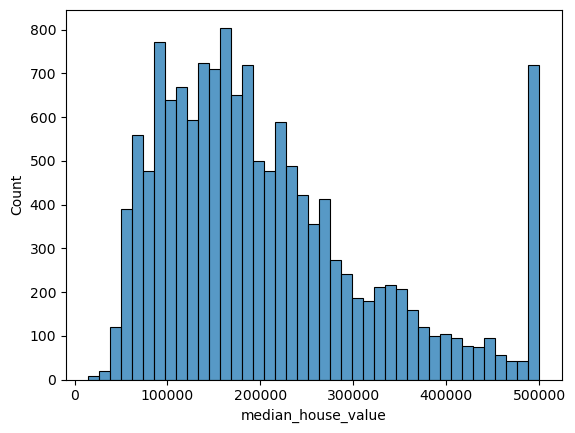

In [13]:
sns.histplot(data=training_data,
             x='median_house_value')

It looks like there has been a long tail of high prices that have all been rounded to 500001.0.

In [14]:
training_data['median_house_value'].value_counts().head()

median_house_value
500001.0    674
137500.0     81
162500.0     78
112500.0     70
225000.0     62
Name: count, dtype: int64

<Axes: xlabel='latitude', ylabel='longitude'>

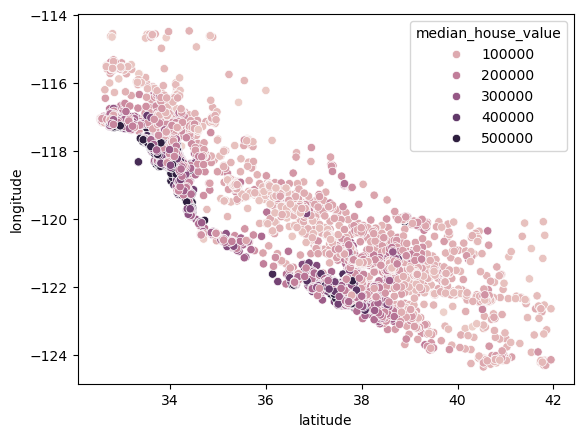

In [15]:
sns.scatterplot(data=training_data,
                x='latitude',
                y='longitude',
                hue='median_house_value')

We have one categorical variable: ocean_proximity. List the possible values and their counts.

In [16]:
training_data['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     6373
INLAND        4477
NEAR OCEAN    1834
NEAR BAY      1617
ISLAND           2
Name: count, dtype: int64

From the scatterplot above, it looks like ocean proximity is an important variable. Houses nearer the ocean seems to have higher prices.

In [17]:
training_data.groupby('ocean_proximity')['median_house_value'].mean()

ocean_proximity
<1H OCEAN     240755.180292
INLAND        124612.869556
ISLAND        432350.000000
NEAR BAY      258126.435374
NEAR OCEAN    247711.583424
Name: median_house_value, dtype: float64

Let's graph these values as well.

<Axes: xlabel='ocean_proximity', ylabel='median_house_value'>

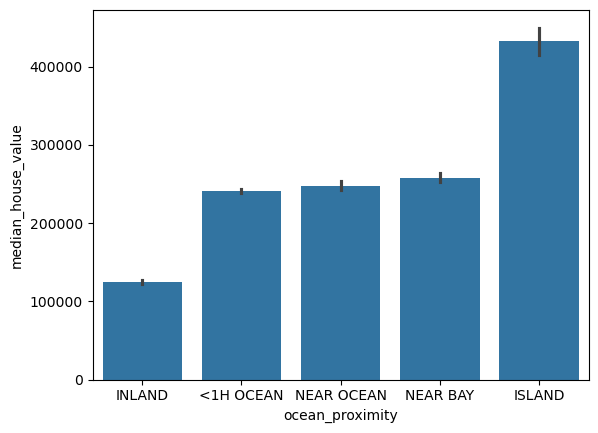

In [18]:
sns.barplot(data=training_data,
            x='ocean_proximity',
            y='median_house_value')

Looking at this, I've decided that it makes sense to order these values from lowest value to highest value:<br>
'INLAND' < '<1H OCEAN' < 'NEAR OCEAN' < 'NEAR BAY' < 'ISLAND'

Because there is a natural order here, it makes sense to use ordinal encoding here rather than one-hot encoding. Unlike with the island in the penguins dataset, in this case it is meaningful for the model to ask if one value of ocean_proximity is greater than another value.

We'll now encode these string values as 0, 1, 2, 3, and 4.

In [19]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
# Define the categories in the desired order for encoding
categories = [['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'NEAR BAY', 'ISLAND']]

# Create the OrdinalEncoder with specified categories
encoder = OrdinalEncoder(categories=categories)

# Replace the values in the ocean_proximity column with the corresponding numeric values
X_train['ocean_proximity'] = encoder.fit_transform(X_train[['ocean_proximity']])

X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
19566,-120.96,37.61,23.0,3497.0,887.0,2467.0,816.0,1.9444,0.0
7292,-118.22,33.98,34.0,2225.0,753.0,2980.0,736.0,1.6685,1.0
17618,-121.94,37.28,27.0,2859.0,464.0,1144.0,430.0,5.0822,1.0
17518,-121.91,37.34,35.0,2189.0,607.0,1193.0,562.0,2.8042,1.0
5172,-118.28,33.95,41.0,835.0,208.0,707.0,192.0,1.4103,1.0
...,...,...,...,...,...,...,...,...,...
11397,-117.97,33.72,24.0,2991.0,500.0,1437.0,453.0,5.4286,1.0
12081,-117.54,33.76,5.0,5846.0,1035.0,3258.0,1001.0,4.7965,1.0
5447,-118.42,34.01,42.0,1594.0,369.0,952.0,362.0,3.0990,1.0
866,-122.04,37.57,12.0,5719.0,1064.0,3436.0,1057.0,5.2879,3.0


Encode the ocean_proximity column in our test data as well:

In [21]:
X_test['ocean_proximity'] = encoder.fit_transform(X_test[['ocean_proximity']])

## Random Forest Regressor

We will now build our random forest regressor model. As you can see, this is very similar to building a decsision tree, or any other type of model in Scikit-learn.

In [22]:
from sklearn.ensemble import RandomForestRegressor

In [23]:
# Initialize the random forest regressor with the default configuration.
# random_state has been initialized so that the same random forest will
# be built each time we run the notebook. 
forest_regressor = RandomForestRegressor(random_state=42)

Fit the regressor to the training data:

In [24]:
forest_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

As with decision tree models, random forests can give us the importance of each feature.

In [25]:
forest_regressor.feature_importances_

array([0.10767793, 0.10216922, 0.05416751, 0.02412903, 0.02291847,
       0.03396716, 0.01935196, 0.48516052, 0.1504582 ])

Next we show the R² score of the model on the training data.

In statistics, the coefficient of determination, denoted R² or r² and pronounced "R squared", is the proportion of the variation in the dependent variable [house prices in this case] that is predictable from the independent variable(s) [our features].
https://en.wikipedia.org/wiki/Coefficient_of_determination

In [26]:
forest_regressor.score(X_train, y_train)

0.9747656739728539

## Comparison with a Single Decision Tree
Let's now compare this with a standard decision tree regressor.

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

We'll use the test set to compare our models. To do this we first use both models to make predictions on the test set.

In [29]:
y_pred_tree = tree_regressor.predict(X_test)
y_pred_forest = forest_regressor.predict(X_test)

As well as R², we'll also compare our models using mean squared error.

Mean squared error (MSE) is the average of the squares of the errors.
https://en.wikipedia.org/wiki/Mean_squared_error

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

Now we can use our predictions and our actual test-set house prices to calculate R² and MSE.

In [31]:
mse_tree = mean_squared_error(y_test, y_pred_tree)
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_tree = r2_score(y_test, y_pred_tree)
r2_forest = r2_score(y_test, y_pred_forest)

In [32]:
print("Decision Tree Mean Squared Error:", mse_tree)
print("Decision Tree R² Score:", r2_tree)
print("\nRandom Forest Squared Error:", mse_forest)
print("Random Forest R² Score:", r2_forest)

Decision Tree Mean Squared Error: 4517192285.16509
Decision Tree R² Score: 0.6611495627696067

Random Forest Squared Error: 2370980682.8127522
Random Forest R² Score: 0.8221444228366392


We can guage how far off the predictions are on average by taking the square root of the mean squared error. Here we check how far off the decision forest's predictions are:

In [33]:
mse_forest ** 0.5

48692.7169380879

## Comparison with Gradient Boosting
Let's now compare our random forest regressor with a gradient boosting regressor.

In [34]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Initialize the HistGradientBoostingRegressor with default settings
hist_regressor = HistGradientBoostingRegressor(random_state=42)

# Fit the HistGradientBoostingRegressor to the training data
hist_regressor.fit(X_train, y_train)

# Make predictions with the HistGradientBoostingRegressor on the test set
y_pred_hist = hist_regressor.predict(X_test)

# Calculate the mean squared error and R² score for the HistGradientBoostingRegressor
mse_hist = mean_squared_error(y_test, y_pred_hist)
r2_hist = r2_score(y_test, y_pred_hist)

# Compare the performance metrics for the HistGradientBoostingRegressor and RandomForestRegressor
print("Random Forest MSE:", mse_forest)
print("HistGradientBoostingRegressor MSE:", mse_hist)
print("\nRandom Forest R²:", r2_forest)
print("HistGradientBoostingRegressor R²:", r2_hist)

Random Forest MSE: 2370980682.8127522
HistGradientBoostingRegressor MSE: 2276617427.0292273

Random Forest R²: 0.8221444228366392
HistGradientBoostingRegressor R²: 0.8292229416293282


## XGBoost

In [35]:
import xgboost as xgb

# Initialize the XGBoost Regressor with default configuration
# xgb_reg = xgb.XGBRegressor(seed=42)

# Alternatively, initialize the XGBRegressor with optimized hyperparameters as calculated here: 
# https://www.kaggle.com/code/zeyadsayedadbullah/california-housing-market-analysis
xgb_reg = xgb.XGBRegressor(n_estimators=878,
                           max_depth=9,
                           learning_rate=0.044560316151882315,
                           subsample=0.815619407603911,
                           colsample_bytree=0.7009722262126873,
                           reg_alpha=6.537887407479665,
                           reg_lambda=6.47817001544571,
                           seed=42)

# Fit the model on the training data
xgb_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_reg.predict(X_test)

# Calculate MSE and R² score for the predictions
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print performance metrics for all three of our ensemble method regressors
print("Random Forest MSE:", mse_forest)
print("HistGradientBoostingRegressor MSE:", mse_hist)
print("XGBoost Mean Squared Error:", mse_xgb)
print("\nRandom Forest R²:", r2_forest)
print("HistGradientBoostingRegressor R²:", r2_hist)
print("XGBoost R² Score:", r2_xgb)

Random Forest MSE: 2370980682.8127522
HistGradientBoostingRegressor MSE: 2276617427.0292273
XGBoost Mean Squared Error: 2037528859.1990328

Random Forest R²: 0.8221444228366392
HistGradientBoostingRegressor R²: 0.8292229416293282
XGBoost R² Score: 0.8471578136984479


Let's now visualise our predicted house prices against our actual test-set house prices. 

First we prepare a DataFrame with the "ground truth" and all of our predictions so far.

In [36]:
predictions = pd.DataFrame()
predictions['ground_truth'] = y_test
predictions['decision_tree'] = y_pred_tree
predictions['random_forest'] = y_pred_forest
predictions['gradiant_boosting'] = y_pred_hist
predictions['xgboost'] = y_pred_xgb

We now plot the "ground truth" against any set of predictions:

<Axes: xlabel='ground_truth', ylabel='decision_tree'>

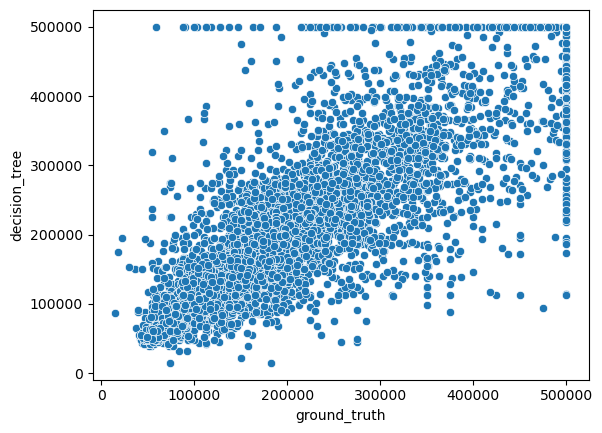

In [37]:
sns.scatterplot(data=predictions,
                x='ground_truth',
                y='decision_tree')

## AdaBoost
AdaBoost is another popular ensemble method, but it is known to be sensitive to outliers. On this dataset, where we didn't deal with the many instances where median_house_value = 500001.0000, we can see that the default AdaBoost regressor has done worse than the other regressors in this demo.

Of course we haven't tried to optimize it, like we did for XGBoost, and we haven't dealt with the problematic data, so don't dismiss it from your growing machine learning toolbox on the result below.

In [38]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(random_state=42)
ada_reg.fit(X_train, y_train)
y_pred_ada = ada_reg.predict(X_test)

mse_ada = mean_squared_error(y_test, y_pred_ada)
r2_ada = r2_score(y_test, y_pred_ada)

print("AdaBoost Mean Squared Error:", mse_ada)
print("AdaBoost R² Score:", r2_ada)


AdaBoost Mean Squared Error: 8441417437.185779
AdaBoost R² Score: 0.36677967001129574


In [39]:
predictions['adaboost'] = y_pred_ada

<Axes: xlabel='ground_truth', ylabel='adaboost'>

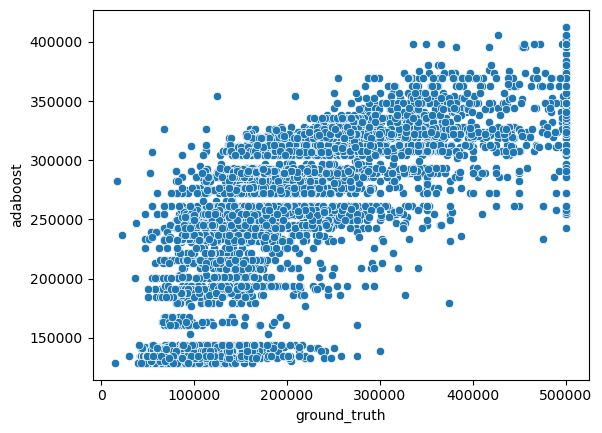

In [40]:
sns.scatterplot(data=predictions,
                x='ground_truth',
                y='adaboost')